In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow as tf
import pathlib

import shutil
import os
from functools import partial

In [ ]:
def zero_pad(X, pad):
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode='constant', constant_values=0)

    return X_pad

zero_pad: pads the image zeros or any value specified as pad (3, 5, etc.)

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)


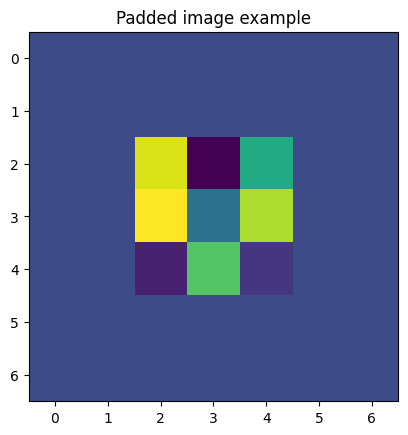

In [ ]:
# Testing
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)

print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)

# Show a padded image
import matplotlib.pyplot as plt
plt.imshow(x_pad[0, :, :, 0])
plt.title("Padded image example")
plt.show()

In [ ]:
def conv_single_step(a_slice_prev, W, b):
    s = a_slice_prev * W
    Z = np.sum(s)
    Z = Z + float(b)

    return Z

a_slice_prev: small patch of the input image with full depth
W: weights of each cell of the filter grid
b: bias
Places the filter on the patch a_slice_prev (multiplication), adds all values and puts them in Z


In [ ]:
# Testing
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.999089450680221


/tmp/ipython-input-1308828854.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z = Z + float(b)


In [ ]:
def conv_forward(A_prev, W, b, hparameters):
    # Forward prop

    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape

    stride = hparameters['stride']
    pad = hparameters['pad']

    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1

    Z = np.zeros((m, n_H, n_W, n_C))
    A_prev_pad = zero_pad(A_prev, pad)

    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        for h in range(n_H):
            vert_start = h * stride
            vert_end = vert_start + f

            for w in range(n_W):
                horiz_start = w * stride
                horiz_end = horiz_start + f

                for c in range(n_C):
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    weights = W[:, :, :, c]
                    biases = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)


    cache = (A_prev, W, b, hparameters)

    return Z, cache

Firstly, gets dimensions of the input A_prev and filter W, and hyperparameters like pad and stride, uses the formula to calculate output shape
Then adds the padding around A_prev and stores the results in Z

for i in range(m): -> For every trianing example
for h in range(n_H): -> Moves row by row
for w in range(n_W): -> Moves column by column
for c in range(n_C): -> All filters are applied

Find the patch, perform the convolution, store the result, cache it for backprop

In [ ]:
# Testing
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 2, "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("Z[3,2,1] =", Z[3, 2, 1])

Z's mean = 0.048995203528855794
Z[3,2,1] = [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]


/tmp/ipython-input-1308828854.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z = Z + float(b)


In [ ]:
def pool_forward(A_prev, hparameters, mode="max"):
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    f = hparameters["f"]
    stride = hparameters["stride"]

    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev

    A = np.zeros((m, n_H, n_W, n_C))

    for i in range(m):
        for h in range(n_H):
            vert_start = h * stride
            vert_end = vert_start + f
            for w in range(n_W):
                horiz_start = w * stride
                horiz_end = horiz_start + f
                for c in range(n_C):
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)

    cache = (A_prev, hparameters)

    assert(A.shape == (m, n_H, n_W, n_C))

    return A, cache

Same as the last function, pass through small patches and store the average or max value of that patch

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)

mode = max
A = [[[[1.74481176 0.86540763 1.13376944]]]


 [[[1.13162939 1.51981682 2.18557541]]]]


In [ ]:
def create_mask_from_window(x):
    mask = (x == np.max(x))
    return mask

def distribute_value(dz, shape):
    (n_H, n_W) = shape
    average = dz / (n_H * n_W)
    a = np.ones(shape) * average
    return a

In [ ]:
def conv_backward(dZ, cache):
    (A_prev, W, b, hparameters) = cache

    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    (f, f, n_C_prev, n_C) = W.shape

    stride = hparameters["stride"]
    pad = hparameters["pad"]

    (m, n_H, n_W, n_C) = dZ.shape

    dA_prev = np.zeros(A_prev.shape)
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)

    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]

        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f

                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]

        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]

    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))

    return dA_prev, dW, db

In [ ]:
def pool_backward(dA, cache, mode = "max"):
    (A_prev, hparameters) = cache

    stride = hparameters["stride"]
    f = hparameters["f"]

    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape

    dA_prev = np.zeros(A_prev.shape)

    for i in range(m):
        a_prev = A_prev[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f

                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += mask * dA[i, h, w, c]

                    elif mode == "average":
                        da = dA[i, h, w, c]
                        shape = (f, f)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)

    assert(dA_prev.shape == A_prev.shape)

    return dA_prev



In [ ]:
def relu_forward(Z):
    A = np.maximum(0, Z)
    cache = Z # Cache Z for backpropagation
    return A, cache

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)

    dZ[Z <= 0] = 0

    return dZ

In [ ]:
# Forward pass here needs flattened input (in the main model)

def fc_forward(A_prev_flat, W, b):
    Z = np.dot(W, A_prev_flat) + b
    cache = (A_prev_flat, W, b)
    return Z, cache

def fc_backward(dZ, cache):
    A_prev_flat, W, b = cache
    m = A_prev_flat.shape[1]

    dW = (1/m) * np.dot(dZ, A_prev_flat.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev_flat = np.dot(W.T, dZ)

    return dA_prev_flat, dW, db

In [ ]:
def initialize_parameters_flowers(input_height, input_width, num_classes):
    np.random.seed(1)

    # Convolutional layer (8 filters of size 4 x 4, input has 3 colour channels)
    W1 = np.random.randn(4, 4, 3, 8) * 0.01
    b1 = np.zeros((1, 1, 1, 8))

    h_after_conv = int((input_height - 4 + 2*1) / 1) + 1
    w_after_conv = int((input_width - 4 + 2*1) / 1) + 1

    h_after_pool = int((h_after_conv - 2) / 2) + 1
    w_after_pool = int((w_after_conv - 2) / 2) + 1

    flattened_size = h_after_pool * w_after_pool * 8


    W2 = np.random.randn(num_classes, flattened_size) * 0.01
    b2 = np.zeros((num_classes, 1))

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

    return parameters


In [ ]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    # To avoid log(0)
    epsilon = 1e-8
    cost = - (1/m) * np.sum(Y * np.log(AL + epsilon))
    cost = np.squeeze(cost)
    return cost

def model_forward(X, parameters, hparameters_conv, hparameters_pool):
    # CONV -> RELU -> POOL -> FLATTEN -> FC
    caches = []

    W1, b1 = parameters['W1'], parameters['b1']
    W2, b2 = parameters['W2'], parameters['b2']

    # CONV layer
    Z1, conv_cache = conv_forward(X, W1, b1, hparameters_conv)
    caches.append(conv_cache)

    # RELU activation
    A1, relu_cache = relu_forward(Z1)
    caches.append(relu_cache)

    # POOL layer
    A2, pool_cache = pool_forward(A1, hparameters_pool, mode="max")
    caches.append(pool_cache)

    # FLATTEN
    # Store original shape to unflatten in backprop
    (m, n_H, n_W, n_C) = A2.shape
    flatten_cache = A2.shape
    caches.append(flatten_cache)
    A2_flat = A2.reshape(m, -1).T

    # FULLY CONNECTED layer
    Z3, fc_cache = fc_forward(A2_flat, W2, b2)
    caches.append(fc_cache)

    # SOFTMAX final layer
    AL = np.exp(Z3) / np.sum(np.exp(Z3), axis=0)

    return AL, caches


def model_backward(AL, Y, caches):
    grads = {}
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    (conv_cache, relu_cache, pool_cache, flatten_cache, fc_cache) = caches

    dZ3 = AL - Y

    # FULLY CONNECTED backward
    A2_flat, W2, b2 = fc_cache
    dA2_flat, dW2, db2 = fc_backward(dZ3, fc_cache)
    grads["dW2"] = dW2
    grads["db2"] = db2

    # UNFLATTEN
    original_shape = flatten_cache
    dA2 = dA2_flat.T.reshape(original_shape)

    # POOL backward
    dA1 = pool_backward(dA2, pool_cache, mode="max")

    # RELU backward
    dZ1 = relu_backward(dA1, relu_cache)

    # CONV backward
    dA0, dW1, db1 = conv_backward(dZ1, conv_cache)
    grads["dW1"] = dW1
    grads["db1"] = db1

    return grads

def update_parameters(parameters, grads, learning_rate):
    parameters["W1"] -= learning_rate * grads["dW1"]
    parameters["b1"] -= learning_rate * grads["db1"]
    parameters["W2"] -= learning_rate * grads["dW2"]
    parameters["b2"] -= learning_rate * grads["db2"]

    return parameters

In [ ]:
def train_model(X, Y, input_shape, num_classes, learning_rate=0.01, num_epochs=100):
    input_height, input_width, _ = input_shape
    parameters = initialize_parameters_flowers(input_height, input_width, num_classes)
    hparameters_conv = {"pad": 1, "stride": 1}
    hparameters_pool = {"stride": 2, "f": 2}

    costs = []

    for i in range(num_epochs):
        AL, caches = model_forward(X, parameters, hparameters_conv, hparameters_pool)
        cost = compute_cost(AL, Y)
        grads = model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if i % 5 == 0 or i == num_epochs - 1:
            costs.append(cost)
            print(f"Cost after epoch {i}: {cost:.4f}")

    return parameters, costs


In [ ]:
import tensorflow_datasets as tfds

def load_and_preprocess(image_size=(64, 64), max_examples=500):
    (ds_train, ds_validation), ds_info = tfds.load(
        'oxford_flowers102',
        split=['train', 'validation'],
        shuffle_files=True,
        with_info=True,
        as_supervised=True,
    )

    num_classes = ds_info.features['label'].num_classes

    def preprocess(image, label):
        image = tf.image.resize(image, image_size)
        image = image / 255.0
        label = tf.one_hot(label, depth=num_classes)
        return image, label

    ds_train = ds_train.map(preprocess).take(max_examples).cache().batch(max_examples)
    ds_validation = ds_validation.map(preprocess).take(100).cache().batch(100)

    for images, labels in ds_train:
        X_train = images.numpy()
        Y_train = labels.numpy().T

    for images, labels in ds_validation:
        X_val = images.numpy()
        Y_val = labels.numpy().T

    print(f"Data loaded successfully.")
    print(f"X_train shape: {X_train.shape}")
    print(f"Y_train shape: {Y_train.shape}")

    return X_train, Y_train, X_val, Y_val, num_classes

In [ ]:
IMAGE_SIZE = (64, 64)
MAX_EXAMPLES_TO_USE = 500 # Starting small

X_train, Y_train, X_val, Y_val, NUM_CLASSES = load_and_preprocess(
    image_size=IMAGE_SIZE,
    max_examples=MAX_EXAMPLES_TO_USE
)

input_shape = X_train.shape[1:]

trained_parameters, costs_history = train_model(
    X_train,
    Y_train,
    input_shape,
    NUM_CLASSES,
    learning_rate=0.01,
    num_epochs=50 # Try changing, 50 is really slow (tried 40 and 30)
)

print("Training finished")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.FHIN34_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.FHIN34_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.FHIN34_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
Data loaded successfully.
X_train shape: (500, 64, 64, 3)
Y_train shape: (102, 500)


/tmp/ipython-input-1308828854.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z = Z + float(b)


Cost after epoch 0: 4.6264
Cost after epoch 5: 4.6397
